## 第四周：pytorch损失优化。Lossfunction ，optimizer  ，学习率下降策略

### 01、什么是优化器
- PyTorch 中的优化器是用于管理并更新模型中可学习参数的值，使得模型输出更加接近真实标签。

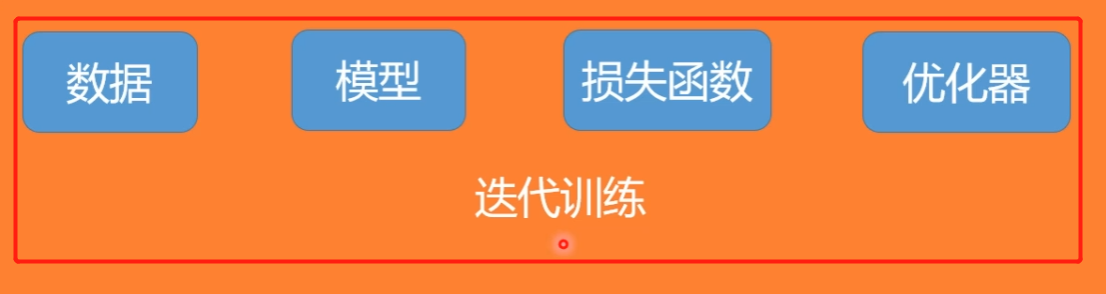

从上面的深度学习训练的步骤中可以看出：
- 第一步：获取数据
- 第二步：构建模型，将数据输入到模型
- 第三步：选择损失函数，进行自动梯度求取
- 第四步：选择优化器，优化器拿到求取的梯度值，去更新模型参数（我们也可以手动设计更新模型参数的策略，不过效果没有人家提供的优化器好）
- 第五步：设定停止的条件，迭代训练网络

### 02、optimizer 的属性

PyTorch 中提供了 Optimizer 类，定义如下：

In [2]:
class Optimizer(object):
    def __init__(self, params, defaults):
        self.defaults = defaults
        self.state = defaultdict(dict)
        self.param_groups = []

主要有 3 个属性：
- defaults：优化器的超参数，如 weight_decay，momentum
- state：参数的缓存，如 momentum 中需要用到前几次的梯度，就缓存在这个变量中
- param_groups：管理的参数组，是一个 list，其中每个元素是字典，包括 momentum、lr、weight_decay、params 等。
- _step_count：记录更新 次数，在学习率调整中使用

###  03、优化器中常用的方法

####  zero_grad()
- 清空所管理参数的梯度。
- 由于 PyTorch 的特性是张量的梯度不自动清零，因此每次反向传播之后都需要清空梯度。

代码如下：

In [4]:
def zero_grad(self):
    r"""Clears the gradients of all optimized :class:`torch.Tensor` s."""
    for group in self.param_groups:
        for p in group['params']:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

#### step()
- 执行一步梯度更新

####  add_param_group()
- 添加参数组
- 对模型进行分组，设置不同的学习率，例如：特征提取的网络学习率比较小，分类的全连接网络层的学习率比较大

主要代码如下：最后有一个append操作，把添加的信息存放到param_group列表中

In [7]:
def add_param_group(self, param_group):
    params = param_group['params']
    if isinstance(params, torch.Tensor):
        param_group['params'] = [params]
    self.param_groups.append(param_group)

#### state_dict()
- 获取优化器当前状态信息字典

In [2]:
def state_dict(self):
    return{
        'state':packed_state,
        'param_groups':param_groups,
    }

#### load_state_dict()
- 加载状态信息字典，包括 state 、momentum_buffer 和 param_groups。主要用于模型的断点续训练。我们可以在每隔 50 个 epoch 就保存模型的 state_dict 到硬盘，在意外终止训练时，可以继续加载上次保存的状态，继续训练。

<font color='red'>state_dict()和load_state_dict()方法配合使用，一个用于存储优化器的状态信息，一个用于加载优化器的状态信息，之所以要存储优化器的状态信息是一方面为了防止出现意外(训练过程中机器出现问题)，另一方面是为了方便获取模型训练过程中的最优值(模型并不是训练的次数越多越好)，一般在10个或者20个epoch存储一次优化器状态信息</font>    

#### 代码演示

In [11]:
import os
import random
import torch
import numpy as np
import torch.optim as optim
BASE_DIR = os.path.dirname("F:\\")

def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
set_seed(1)  # 设置随机种子

# 随机生成权重张量
weight = torch.randn((2, 2), requires_grad=True)
# 手动赋值权重梯度
weight.grad = torch.ones((2, 2))

# 创建优化器
optimizer = optim.SGD([weight], lr=1)


# ------------------step()方法：执行一次梯度更新 --------------------------------
flag = 0
# flag = 1
if flag:
    print("weight before step:{}".format(weight.data))
    optimizer.step()        # 修改lr=1 0.1观察结果
    print("weight after step:{}".format(weight.data))


# ----------------------------------- zero_grad -----------------------------------
flag = 0
#flag = 1
if flag:
    print("weight before step:{}".format(weight.data))
    optimizer.step()        # 修改lr=1 0.1观察结果
    print("weight after step:{}".format(weight.data))

    # 地址相同
    print("weight in optimizer:{}\nweight in weight:{}\n".format(id(optimizer.param_groups[0]['params'][0]), id(weight)))

    print("weight.grad is {}\n".format(weight.grad))
    optimizer.zero_grad()
    print("after optimizer.zero_grad(), weight.grad is\n{}".format(weight.grad))


# ----------------------------------- add_param_group -----------------------------------
flag = 0
# flag = 1
if flag:
    # 打印优化器参数(只有一组)
    print("optimizer.param_groups is\n{}".format(optimizer.param_groups))
    
    # 创建第二组参数
    w2 = torch.randn((3, 3), requires_grad=True)

    # 使用add_param_group方法将第二组方法添加到优化器
    optimizer.add_param_group({"params": w2, 'lr': 0.0001})

    # 打印优化器参数(有两组)
    print("optimizer.param_groups is\n{}".format(optimizer.param_groups))

# ----------------------------------- state_dict -----------------------------------
flag = 0
# flag = 1
if flag:
    # 创建一个优化器
    optimizer = optim.SGD([weight], lr=0.1, momentum=0.9)
    # 存储优化器信息
    opt_state_dict = optimizer.state_dict()
    # 打印优化器信息
    print("state_dict before step:\n", opt_state_dict)
    
    # 更新
    for i in range(10):
        optimizer.step()

    # 打印优化器信息
    print("state_dict after step:\n", optimizer.state_dict())
    
    # 保存到本地文件
    torch.save(optimizer.state_dict(), os.path.join(BASE_DIR, "optimizer_state_dict.pkl"))

# -----------------------------------load state_dict -----------------------------------
#flag = 0
flag = 1
if flag:
    # 创建一个优化器
    optimizer = optim.SGD([weight], lr=0.1, momentum=0.9)
    
    # 加载优化器信息文件
    state_dict = torch.load(os.path.join(BASE_DIR, "optimizer_state_dict.pkl"))
    
    # 打印优化器信息
    print("state_dict before load state:\n", optimizer.state_dict())
    
    # 将加载的优化器信息加载到优化器
    optimizer.load_state_dict(state_dict)
    
    #打印优化器信息
    print("state_dict after load state:\n", optimizer.state_dict())

state_dict before load state:
 {'state': {}, 'param_groups': [{'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [0]}]}
state_dict after load state:
 {'state': {0: {'momentum_buffer': tensor([[6.5132, 6.5132],
        [6.5132, 6.5132]])}}, 'param_groups': [{'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [0]}]}


### 04、学习率

学习率是影响损失函数收敛的重要因素，控制了梯度下降更新的步伐。

下面构造一个损失函数 $y=(2x)^{2}$
- $x$ 的初始值为 2，学习率设置为 1，运行看看效果，结果是发散的
- $x$ 的初始值为 2，学习率设置为 0.1，运行看看效果，结果是收敛的

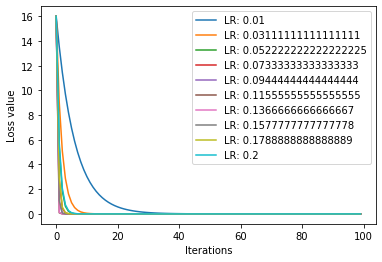

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(1)

# 定义一个函数
def func(x_t):
    """
    y = (2x)^2 = 4*x^2      dy/dx = 8x
    """
    return torch.pow(2*x_t, 2)


# 初始化x的值为2
x = torch.tensor([2.], requires_grad=True)


# -----------------使用生成的点：画出函数图---------------------
flag=0
# flag=1
if flag:
    x_t = torch.linspace(-3, 3, 100) # 生成数据
    y = func(x_t) # 求取对应y值
    plt.plot(x_t.numpy(), y.numpy(), label="y = 4*x^2") # 绘制图
    plt.grid()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()


# ------------------梯度下降：不带动量-------------------------
flag=0
#flag=1
if flag:
    # 定义三个列表来存储数值
    iter_rec, loss_rec, x_rec = list(), list(), list()
    
    # 设置学习率
    # lr=1
    lr = 0.1    

    # 设置迭代次数
    max_iteration = 5 

    # 迭代训练
    for i in range(max_iteration):
        # 函数
        y = func(x)
        # 梯度求取
        y.backward()
        # 打印值
        print("Iter:{:2}, X:{:22}, X.grad:{:22}, loss:{:22}".format(
            i, x.detach().numpy()[0], x.grad.detach().numpy()[0], y.item()))
        
        # 获取张量里面的元素值，存入列表
        x_rec.append(x.item())
        
        # 梯度更新
        x.data.sub_(lr * x.grad)    # x -= x.grad  数学表达式意义:  x = x - x.grad    # 0.5 0.2 0.1 0.125
        # 梯度置零
        x.grad.zero_()
        
        iter_rec.append(i)
        loss_rec.append(y)

    plt.subplot(121).plot(iter_rec, loss_rec, '-ro')
    plt.xlabel("Iteration")
    plt.ylabel("Loss value")

    x_t = torch.linspace(-3, 3, 100)
    y = func(x_t)
    plt.subplot(122).plot(x_t.numpy(), y.numpy(), label="y = 4*x^2")
    plt.grid()
    y_rec = [func(torch.tensor(i)).item() for i in x_rec]
    plt.subplot(122).plot(x_rec, y_rec, '-ro')
    plt.legend()
    plt.show()

# ---试验 10 个不同的学习率 ，[0.01, 0.2] 之间线性选择 10 个学习率，并比较损失函数的收敛情况 ---
# flag = 0
flag = 1
if flag:
    iteration = 100
    num_lr = 10
    lr_min, lr_max = 0.01, 0.2  # .5 .3 .2

    lr_list = np.linspace(lr_min, lr_max, num=num_lr).tolist()
    loss_rec = [[] for l in range(len(lr_list))]
    iter_rec = list()

    for i, lr in enumerate(lr_list):
        x = torch.tensor([2.], requires_grad=True)
        for iter in range(iteration):

            y = func(x)
            y.backward()
            x.data.sub_(lr * x.grad)  # x.data -= x.grad
            x.grad.zero_()

            loss_rec[i].append(y.item())

    for i, loss_r in enumerate(loss_rec):
        plt.plot(range(len(loss_r)), loss_r, label="LR: {}".format(lr_list[i]))
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Loss value')
    plt.show()

#### 代码分析：
这个损失函数在学习率为 0.125 时最快收敛（但是这个值我们是不知道的），学习率为 0.01 收敛最慢。但是不同模型的最佳学习率不一样，无法事先知道，一般把学习率设置为比较小的数就可以了

###  05、momentum 动量

momentum（动量，冲量）： 结合当前梯度和上一次更新的信息，用于当前更新，

#### momentum来源于指数加权平均(了解)：
- $\mathrm{v_t}={\beta} * {v_{t-1}}+({1}-{\beta}) * {\theta_t}$，其中 $v_{t-1}$ 是上一个时刻的指数加权平均，$\theta_{t}$ 表示当前时刻的值，$\beta$ 是系数，一般小于 1。

- 指数加权平均常用于时间序列求平均值。假设现在求得是 100 个时刻的指数加权平均，那么

- ${v_{100}}={\beta} * {v_{99}}+({1}-{\beta}) * {\theta_{100}}$
- $=({1}-{\beta}) * {\theta_{100}}+{\beta} *({\beta} * {v_{98}}+({1}-{\beta}) * {\theta_{99}})$
- $=({1}-{\beta})*{\beta}^{0} * {\theta_{100}}+({1}-{\beta}) * {\beta}^{1} * {\theta_{99}}+\left({\beta}^{2} * {v}_{98} \right)$
- $=\sum_{i}^{N}(\mathbf{1}-\boldsymbol{\beta}) * \boldsymbol{\beta}^{i} * \boldsymbol{\theta}_{N-i}$

从上式可以看到，由于 $\beta$ 小于 1，时刻越靠前的 $\theta$，$\beta$ 的次方就越大，系数就越小。

$\beta$ 可以理解为记忆周期，$\beta$ 越小，记忆周期越短，$\beta$ 越大，记忆周期越长。通常 $\beta$ 设置为 0.9，那么 $\frac{1}{1-\beta}=\frac{1}{1-0.9}=10$，表示更关注最近 10 个时刻的数据。

<font color='red'>$\beta$ 的值越大，记忆周期越长，就会更多考虑前面时刻的数值，因此越平缓</font>

#### 使用代码验证一下

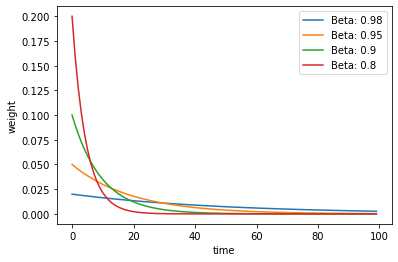

In [41]:
import torch
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(1)

# 定义一个函数，生成一个beta的list
def exp_w_func(beta, time_list):
    return [(1 - beta) * np.power(beta, exp) for exp in time_list]

# 定义beta的值为0.9
beta = 0.9
# 100个时刻
num_point = 100
# np.arange：一个参数时，参数值为终点，起点取默认值0，步长取默认值1
# tolist()：将矩阵（matrix）和数组（array）转化为列表
time_list = np.arange(num_point).tolist()

# ----------指数加权平均的系数----------------
flag = 0
# flag = 1
if flag:
    weights = exp_w_func(beta, time_list)

    plt.plot(time_list, weights, '-ro', label="Beta: {}\ny = B^t * (1-B)".format(beta))
    plt.xlabel("time")
    plt.ylabel("weight")
    plt.legend()
    plt.title("exponentially weighted average")
    plt.show()

    print(np.sum(weights))


# ---------不同beta值：指数加权平均的系数------------
# flag = 0
flag = 1
if flag:
    beta_list = [0.98, 0.95, 0.9, 0.8]
    w_list = [exp_w_func(beta, time_list) for beta in beta_list]
    for i, w in enumerate(w_list):
        plt.plot(time_list, w, label="Beta: {}".format(beta_list[i]))
        plt.xlabel("time")
        plt.ylabel("weight")
    plt.legend()
    plt.show()

#### 在 PyTroch 中，momentum 的更新公式是：
梯度下降公式：
- $w_{i+1}=w_i-lr*g(w_i)$

pytorch中的更新公式：
- $v_{i}=m * v_{i-1}+g(w_{i})$
- $w_{i+1}=w_{i}-lr * v_{i}$

    - $w_{i+1}$ 表示第 $i+1$ 次更新的参数
    - lr 表示学习率
    - $v_{i}$ 表示更新量
    - $m$ 表示 momentum 系数
    - $g(w_{i})$ 表示 $w_{i}$ 的梯度
    
展开表示如下：

- $v_{100}=m * v_{99}+g(w_{100})$ 
- $=g(w_{100})+ m *( m * v_{98}+g(w_{99})$
- $=g(w_{100})+ m *g(w_{99})+{m}^{2} * v_{98}$
- $=g(w_{100})+m * g(w_{99})+{m}^{2} * {g}(w_{98})+{m}^{3} * {v}_{97}$

有上面的式子可以看出，我们更新的量和之前的更新的量（梯度信息）有关系

下面的代码是构造一个损失函数 $y=(2x)^{2}$，$x$ 的初始值为 2，记录每一次梯度下降并画图，学习率使用 0.01 和 0.03

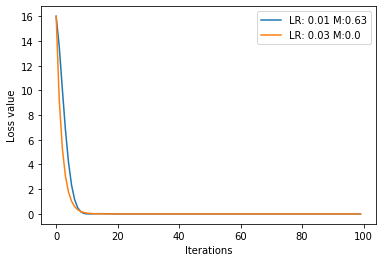

In [43]:
import torch
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(1)
# ---------------SGD momentum ---------------------

def func(x):
    return torch.pow(2*x, 2)    # y = (2x)^2 = 4*x^2        dy/dx = 8x

iteration = 100
m = 0.63     # 0.9

lr_list = [0.01, 0.03]

momentum_list = list()
loss_rec = [[] for l in range(len(lr_list))]
iter_rec = list()

for i, lr in enumerate(lr_list):
    x = torch.tensor([2.], requires_grad=True)

    momentum = 0. if lr == 0.03 else m
    momentum_list.append(momentum)

    optimizer = optim.SGD([x], lr=lr, momentum=momentum)

    for iter in range(iteration):

        y = func(x)
        y.backward()

        optimizer.step()
        optimizer.zero_grad()

        loss_rec[i].append(y.item())

for i, loss_r in enumerate(loss_rec):
    plt.plot(range(len(loss_r)), loss_r, label="LR: {} M:{}".format(lr_list[i], momentum_list[i]))
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss value')
plt.show()

设置合适的momentu可以让小的学习率也可以很快的更新

但是合适的momentum需要不断的实验才能够得到

### 06、PyTroch 提供的优化器


#### optim.SGD
optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False)
- 随机梯度下降法
- params：管理的参数组
- lr：初始学习率
- momentum：动量系数 $\beta$
- weight_decay：L2 正则化系数
- nesterov：是否采用 NAG

#### 其他的优化器
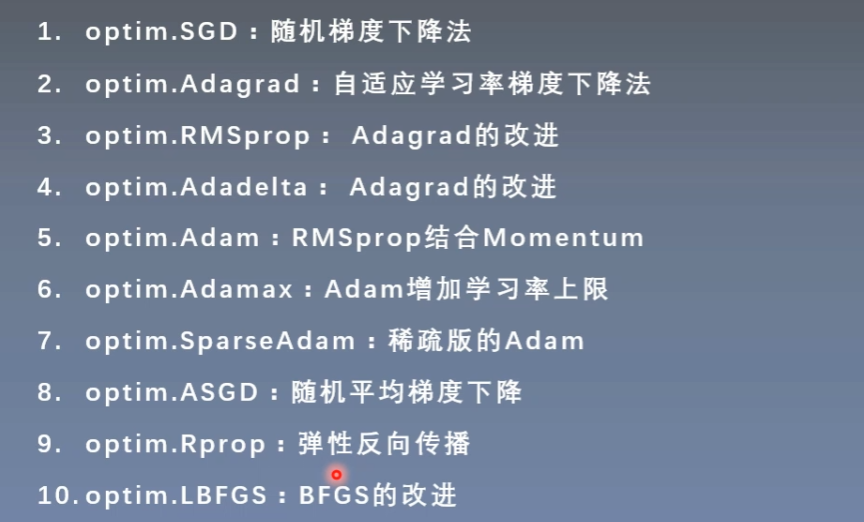